# Crime prediction in St Louis City

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from datetime import datetime
from datetime import timedelta 
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler

# Preprocessing data

In [122]:
#importing dataset
data=pd.read_csv('stl-crime-data_2008-2015.tsv',delimiter='\t',encoding='utf-8')
data = data[['DateOccured','Neighborhood','UCRCrime']]
data['DateOccured'] = [datetime.strptime(data.iloc[i]['DateOccured'], '%m/%d/%Y %H:%M').date() for i in range(len(data.index))]
data

,DateOccured,Neighborhood,UCRCrime
0,2000-01-01,53,Sex Offenses
1,2003-01-01,17,Larceny-theft
2,2004-01-01,68,Fraud
3,2006-01-01,16,Fraud
4,2007-01-01,57,Other assaults
...,...,...,...
477636,2013-12-01,5,Larceny-theft
477637,2013-12-20,65,Forcible Rape
477638,2014-12-22,14,Other assaults
477639,2014-12-26,60,Robbery


In [0]:
#keeping dates starting 2008
start = datetime.strptime('Jan 1 2008 00:00','%b %d %Y %H:%M').date()
filt = data['DateOccured'] >= start
data = data.where(filt)
data = data.dropna()


In [0]:
mask1 = (data['UCRCrime'] == 'Forcible Rape') | (data['UCRCrime'] == 'Sex Offenses')
data.loc[mask1,'UCRCrime'] = 'Sexual Abuse'
mask2 = ( (data['UCRCrime']=='Larceny-theft') | (data['UCRCrime']=='Fraud') |
         (data['UCRCrime']=='Forgery and Counterfeiting') | (data['UCRCrime']=='Burglary') |
         (data['UCRCrime']=='Arson') | (data['UCRCrime']=='Robbery') | (data['UCRCrime']=='Embezzlement') |
         (data['UCRCrime']== 'Stolen Property') | (data['UCRCrime']=='Motor vehicle theft') )
data.loc[mask2,'UCRCrime'] = 'Property Crimes'
mask3 = ( (data['UCRCrime']=='Aggravated Assault') | (data['UCRCrime']=='Other assaults') |
         (data['UCRCrime']=='Criminal Homicide') | (data['UCRCrime']=='Offenses Against the Family and Children') )
data.loc[mask3,'UCRCrime'] = 'Violence'
mask4 = ( (data['UCRCrime']=='Vandalism') | (data['UCRCrime']=='Vagrancy') | (data['UCRCrime']=='Gambling') |
         (data['UCRCrime']=='Prostitution and Commercialized Vice') | (data['UCRCrime']=='Weapons') )
data.loc[mask4,'UCRCrime'] = 'Vice'
mask5 = ( (data['UCRCrime']=='Disorderly Conduct') | (data['UCRCrime']=='DUI') |
         (data['UCRCrime']=='Liquor Laws') | (data['UCRCrime']=='Drug Abuse Violations') )
data.loc[mask5,'UCRCrime'] = 'Substance Abuse'

In [0]:
#compute count for each day and each crime category and store in dictionary
dico = data.groupby(['DateOccured','UCRCrime']).count().to_dict()['Neighborhood']
#create new df that will contain count for each category and each day
df = pd.DataFrame(columns=['Date']+list(data['UCRCrime'].unique()))

In [0]:
n_days = 2922 #number of days from jan 1st 2008 to dec 31st 2015
df['Date'] = [start+timedelta(days = i)  for i in range(n_days)]


In [0]:
#filling df with values from dict
for i in range(len(df.index)):
  for crime in ['Sexual Abuse',	'Property Crimes',	'Violence',	'Other',	'Vice',	'Substance Abuse']:
    if (start+timedelta(days=i),crime) in dico.keys():
      df.iloc[i][crime] = dico[(start+timedelta(days=i),crime)]
    else:
      df.iloc[i][crime] = 0

In [128]:
#making sure no Nan values are left
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             2922 non-null   object
 1   Sexual Abuse     2922 non-null   object
 2   Property Crimes  2922 non-null   object
 3   Violence         2922 non-null   object
 4   Other            2922 non-null   object
 5   Vice             2922 non-null   object
 6   Substance Abuse  2922 non-null   object
dtypes: object(7)
memory usage: 159.9+ KB


In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [132]:
df

,Date,Sexual Abuse,Property Crimes,Violence,Other,Vice,Substance Abuse
0,2008-01-01,24,137,43,2,30,12
1,2008-01-02,1,111,12,6,28,15
2,2008-01-03,1,98,12,8,25,16
3,2008-01-04,1,133,24,11,16,14
4,2008-01-05,4,127,27,10,25,13
...,...,...,...,...,...,...,...
2917,2015-12-27,0,36,14,21,8,4
2918,2015-12-28,1,53,12,14,11,5
2919,2015-12-29,1,53,13,16,13,3
2920,2015-12-30,2,38,18,9,12,6


# LSTM implementation

In [158]:
crimes = ['Sexual Abuse',	'Property Crimes',	'Violence',	'Other',	'Vice',	'Substance Abuse']
# load dataset
# choose crime category
dataset = df[crimes[1]]
values = dataset.values
# ensure all data is float
values = values.astype('float32')
values = values.reshape(-1, 1)
# normalize feature
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 1)
# drop columns we don't want to predict
print(reframed.head())

    var1(t-7)  var1(t-6)  var1(t-5)  ...  var1(t-2)  var1(t-1)   var1(t)
7    0.793333   0.620000   0.533333  ...   0.533333   0.626667  0.500000
8    0.620000   0.533333   0.766667  ...   0.626667   0.500000  0.500000
9    0.533333   0.766667   0.726667  ...   0.500000   0.500000  0.633333
10   0.766667   0.726667   0.533333  ...   0.500000   0.633333  0.800000
11   0.726667   0.533333   0.626667  ...   0.633333   0.800000  0.626667

[5 rows x 8 columns]


In [0]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
from keras import regularizers

(2192, 1, 7) (2192,) (723, 1, 7) (723,)
Train on 2192 samples, validate on 723 samples
Epoch 1/50
 - 1s - loss: 0.1594 - val_loss: 0.0653
Epoch 2/50
 - 0s - loss: 0.0979 - val_loss: 0.0715
Epoch 3/50
 - 0s - loss: 0.0957 - val_loss: 0.0670
Epoch 4/50
 - 0s - loss: 0.0960 - val_loss: 0.0716
Epoch 5/50
 - 0s - loss: 0.0943 - val_loss: 0.0724
Epoch 6/50
 - 0s - loss: 0.0923 - val_loss: 0.0690
Epoch 7/50
 - 0s - loss: 0.0941 - val_loss: 0.0735
Epoch 8/50
 - 0s - loss: 0.0947 - val_loss: 0.0783
Epoch 9/50
 - 0s - loss: 0.0942 - val_loss: 0.0735
Epoch 10/50
 - 0s - loss: 0.0940 - val_loss: 0.0758
Epoch 11/50
 - 0s - loss: 0.0942 - val_loss: 0.0718
Epoch 12/50
 - 0s - loss: 0.0934 - val_loss: 0.0763
Epoch 13/50
 - 0s - loss: 0.0924 - val_loss: 0.0699
Epoch 14/50
 - 0s - loss: 0.0932 - val_loss: 0.0748
Epoch 15/50
 - 0s - loss: 0.0924 - val_loss: 0.0774
Epoch 16/50
 - 0s - loss: 0.0923 - val_loss: 0.0776
Epoch 17/50
 - 0s - loss: 0.0932 - val_loss: 0.0665
Epoch 18/50
 - 0s - loss: 0.0905 - val

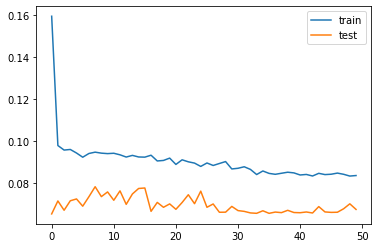

In [160]:
# split into train and test sets
values = reframed.values
n_train_days = 2192 #up to 2013
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),dropout=0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=True)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()